In [254]:
import pennylane as qml
from gate_opt_utils_11 import *
import matplotlib.pyplot as plt
from penny_to_graph_31 import Penny_to_Graph
from graph_utils_1 import *
from quantum_circuit_optimization import *

In [95]:
[ds] = qml.data.load("ketgpt")

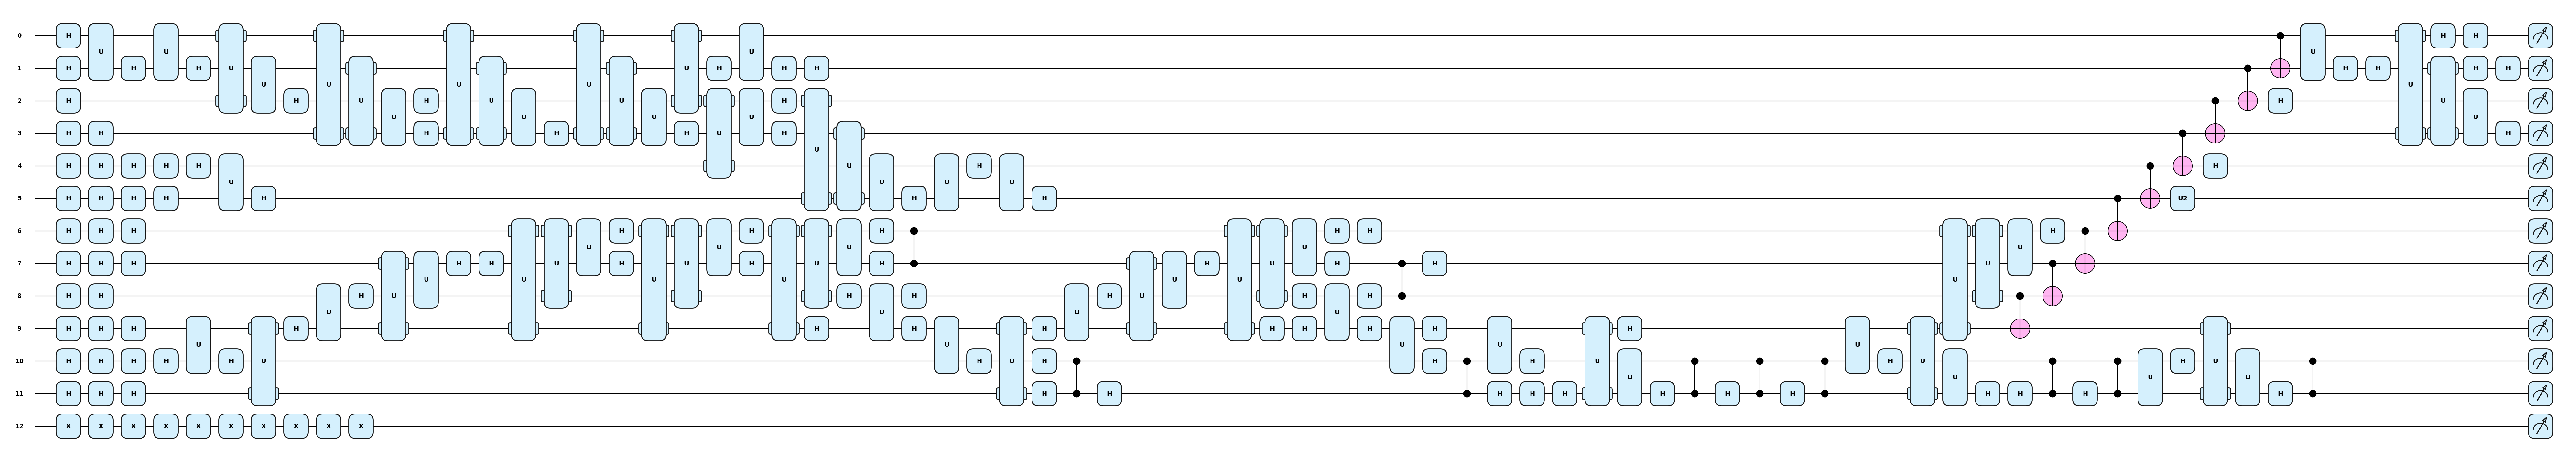

               0
num_qubit     13
num_gate     199
num_1q_gate  116
num_2q_gate   19
unitary       64
depth         66
None


In [96]:
seed = 0

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

fig, axs = qml.draw_mpl(circuit, style='pennylane')()
plt.show()

print(summary_penny(circuit))

               0
num_qubit     12
num_gate     145
num_1q_gate   62
num_2q_gate   19
unitary       64
depth         67
None


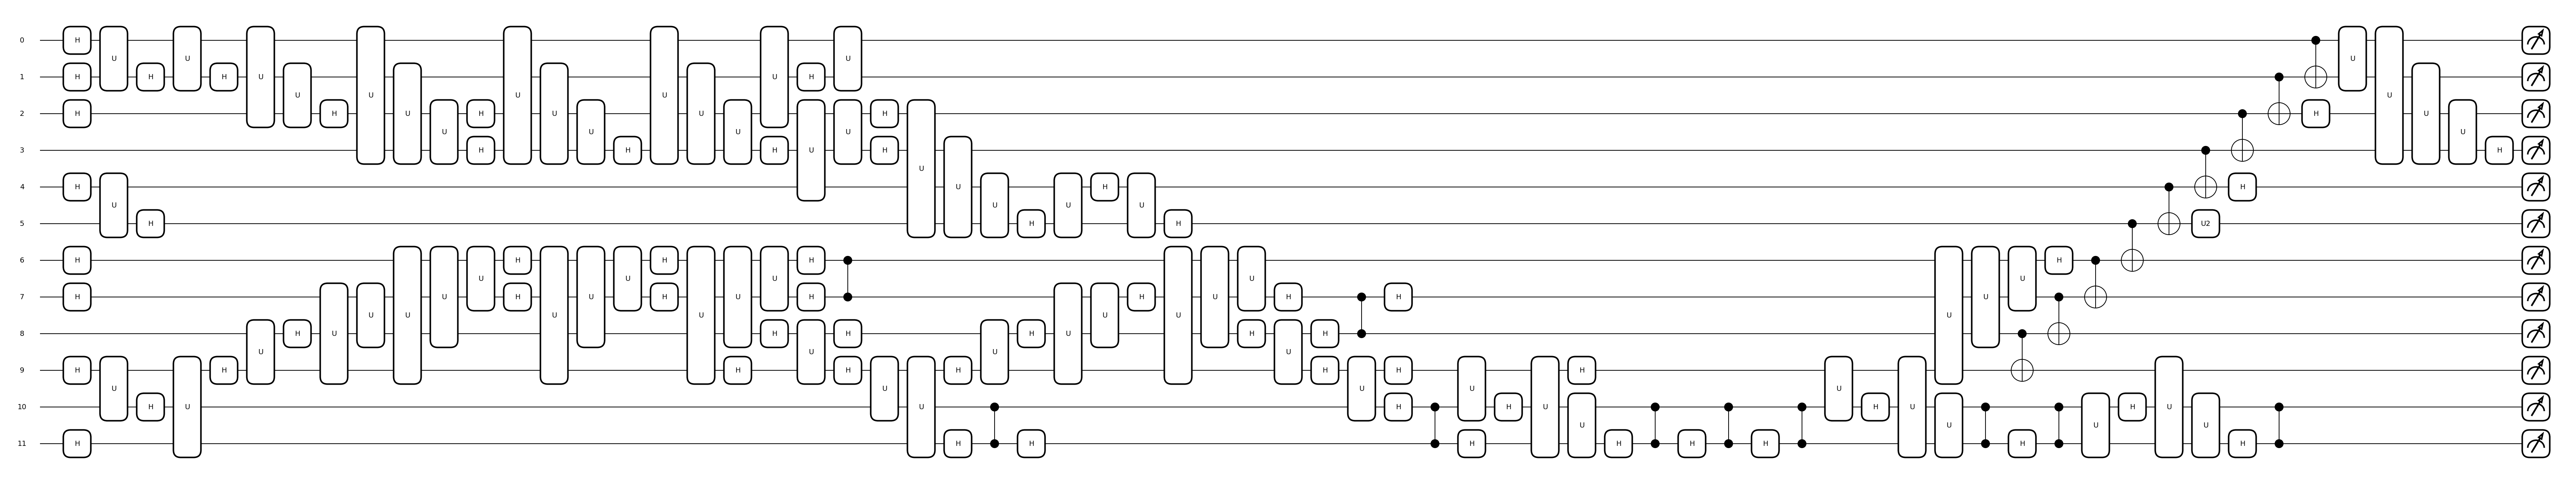

In [97]:
qnode = optimization_lev_1(ds, circuit, seed=0)

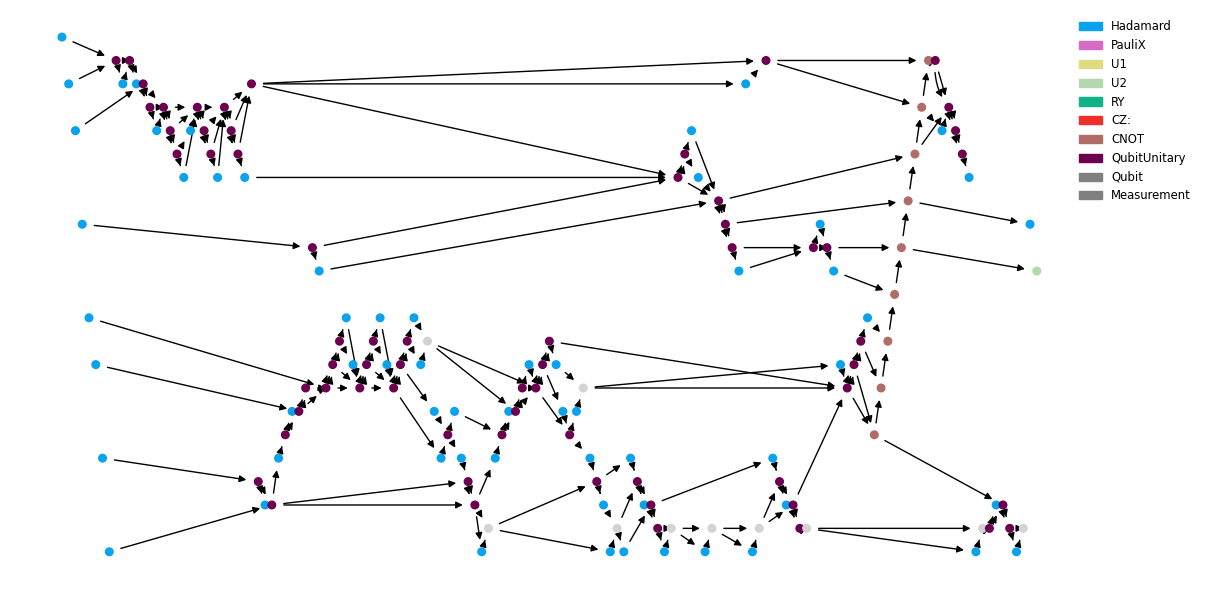

In [247]:
pg = Penny_to_Graph(qnode)
pg.show_graph(pg.G)

In [175]:
# final toutch - number of qubits 
for n, attr in pg.G.nodes(data=True):
    pg.G.nodes[n]['num_q'] = len(attr.get('wires', []))
G = pg.G

In [176]:
pg.G.nodes['Hadamard_0']

{'type': 'gate', 'label': 'Hadamard', 'params': [], 'wires': [0], 'num_q': 1}

In [177]:
# we need to conduct backtracking
subgraphs = []
gate_2q = [n for n, attr in pg.G.nodes(data=True) if attr['num_q'] == 2]

for center in gate_2q:
    radius = 0
    wires = pg.G.nodes[center]['wires']
    prev_subG = None

    while True:
        bool_list = []
        subG = nx.ego_graph(pg.G.to_undirected(), center, radius=radius)
        for node, attr in subG.nodes(data=True):
            bool_list.append(set(attr['wires']).issubset(wires))        

        if bool_list.count(False) > 1:
            if prev_subG is not None:
                subgraphs.append({'center': center, 'wires':wires, 'subG': prev_subG})
            break
        else:
            prev_subG = subG 
            radius += 1

In [178]:
def draw_subgraphs(subgraphs):
    num_subgraphs = len(subgraphs)
    cols = 5
    rows = (num_subgraphs + cols - 1) // cols 

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  
    axes = axes.flatten()  

    for i in range(num_subgraphs):
        nx.draw(subgraphs[i]['subG'], ax=axes[i], with_labels=True)
        axes[i].set_title(subgraphs[i]['center'])

    # Hide any unused axes
    for j in range(num_subgraphs, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

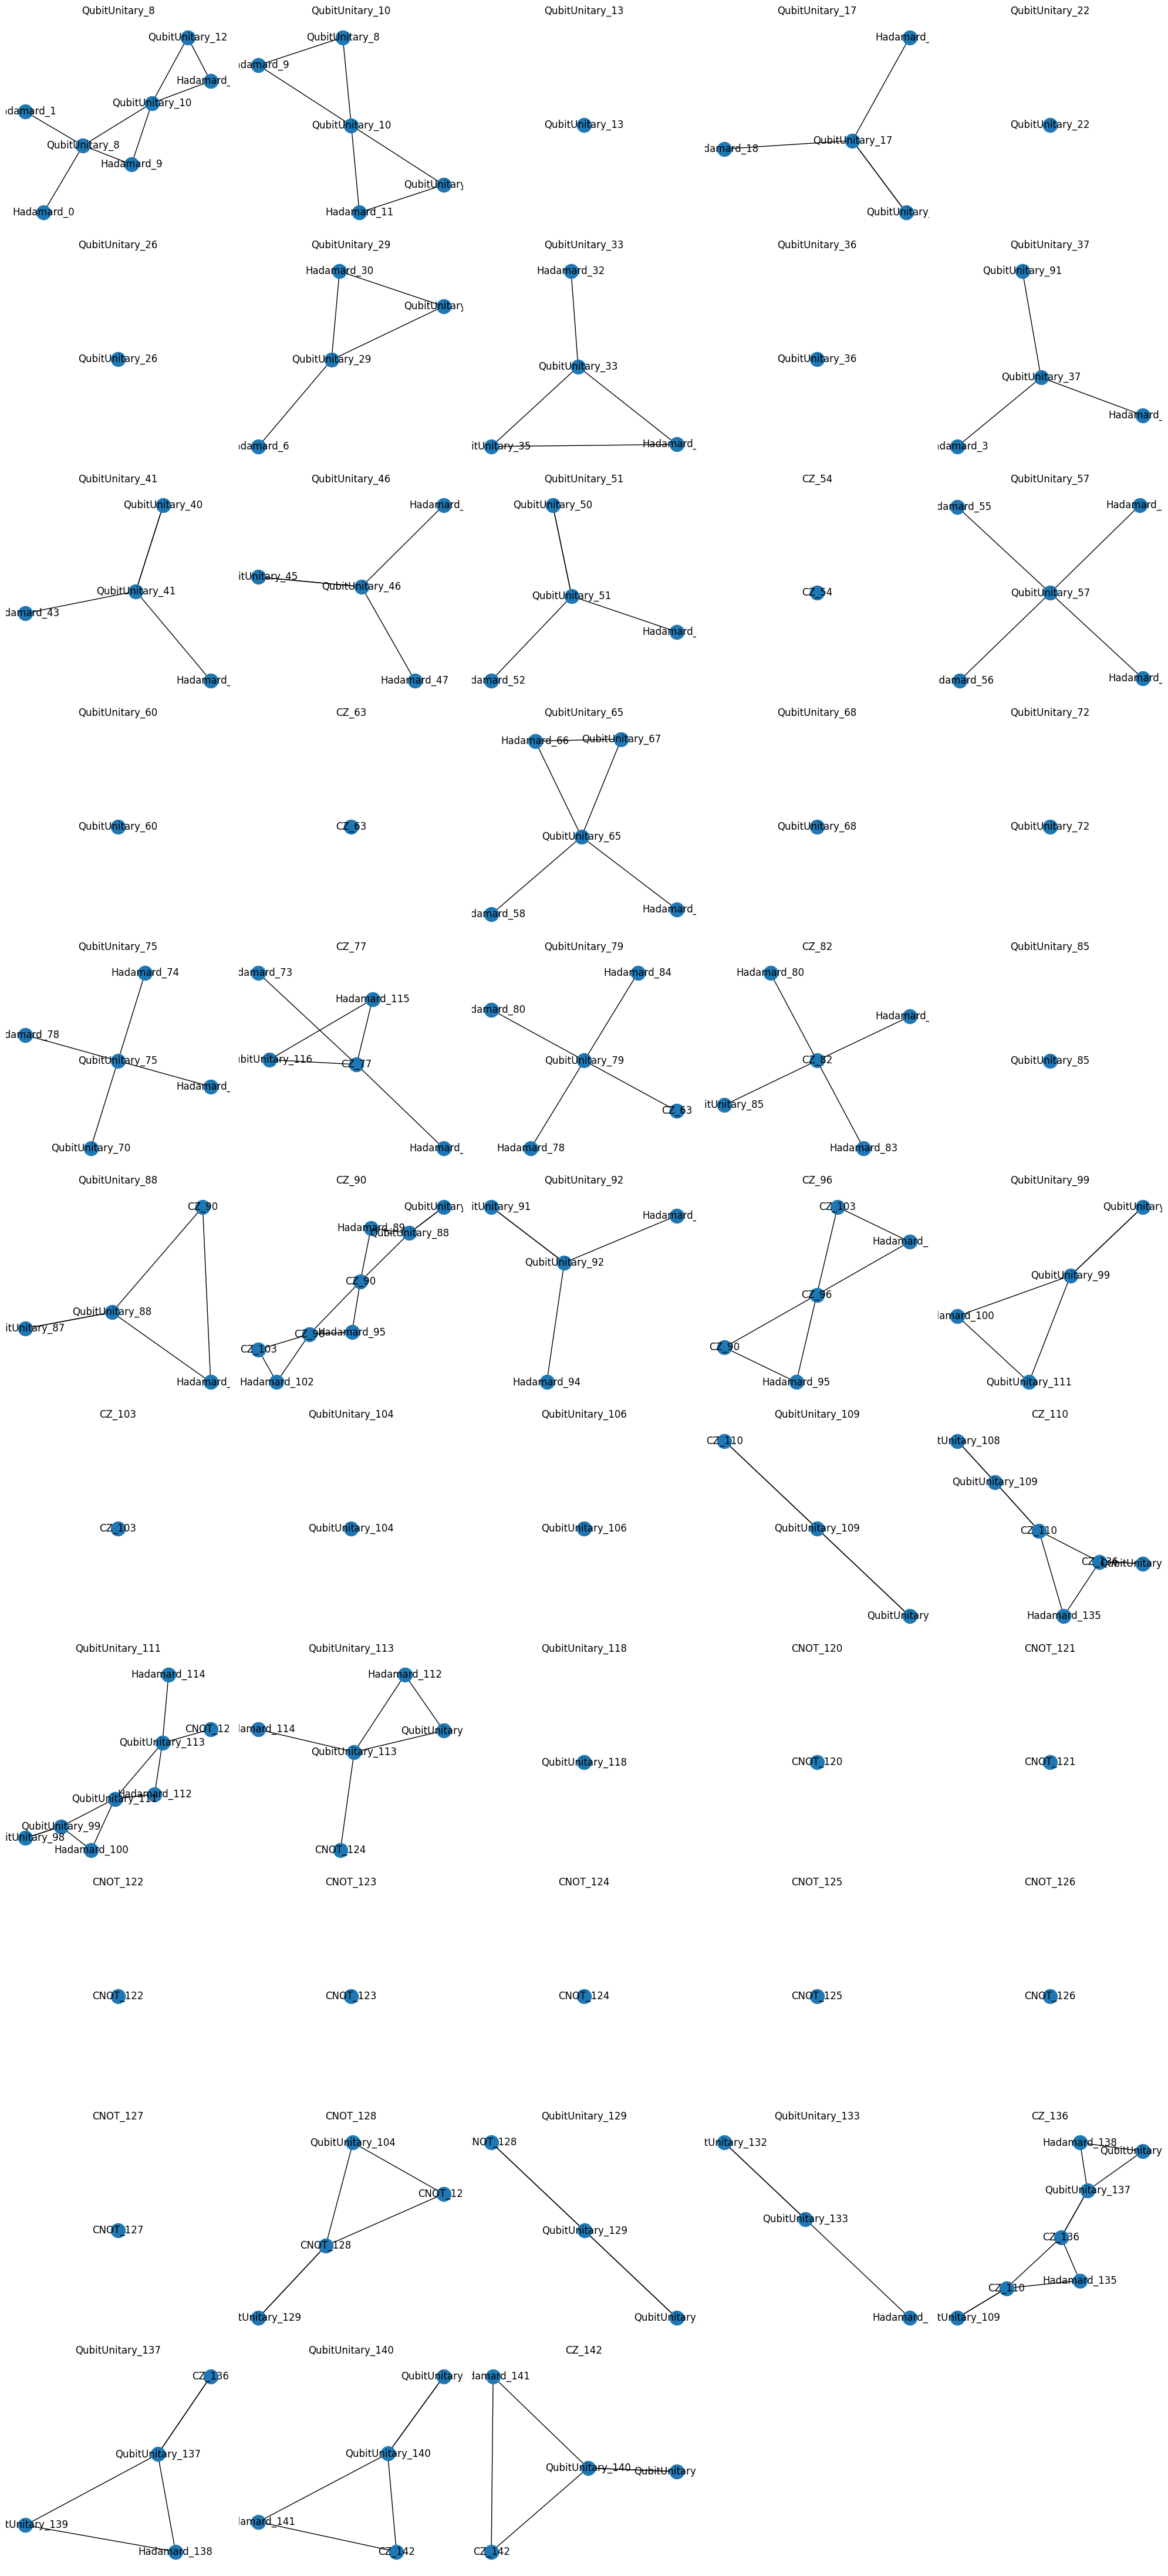

In [179]:
draw_subgraphs(subgraphs)

In [180]:
# change the subgraphs
new_subgraph = subgraphs.copy()
# drop standalone nodes
effective_idx = []
for idx, elem in enumerate(subgraphs):
    if len(elem['subG'].nodes()) == 1:
        continue
    else:
        effective_idx.append(idx)

new_subgraph = [new_subgraph[i] for i in effective_idx]

for idx, elem in enumerate(new_subgraph):
    reference_wires = elem['wires']
    subG = elem['subG'] 
    # remove nodes outside the ference wires
    nodes_to_remove = [
        node for node, attr in subG.nodes(data=True)
        if not set(attr.get('wires', [])).issubset(reference_wires)
    ]
    subG.remove_nodes_from(nodes_to_remove)
    new_subgraph[idx]['subG'] = subG

In [181]:
# concisely,
new_subgraph = [elem for elem in subgraphs if len(elem['subG'].nodes()) > 1]
for elem in new_subgraph:
    reference_wires = set(elem['wires'])
    subG = elem['subG']
    nodes_to_remove = [node for node, attr in subG.nodes(data=True) if not set(attr.get('wires', [])).issubset(reference_wires)]
    subG.remove_nodes_from(nodes_to_remove)

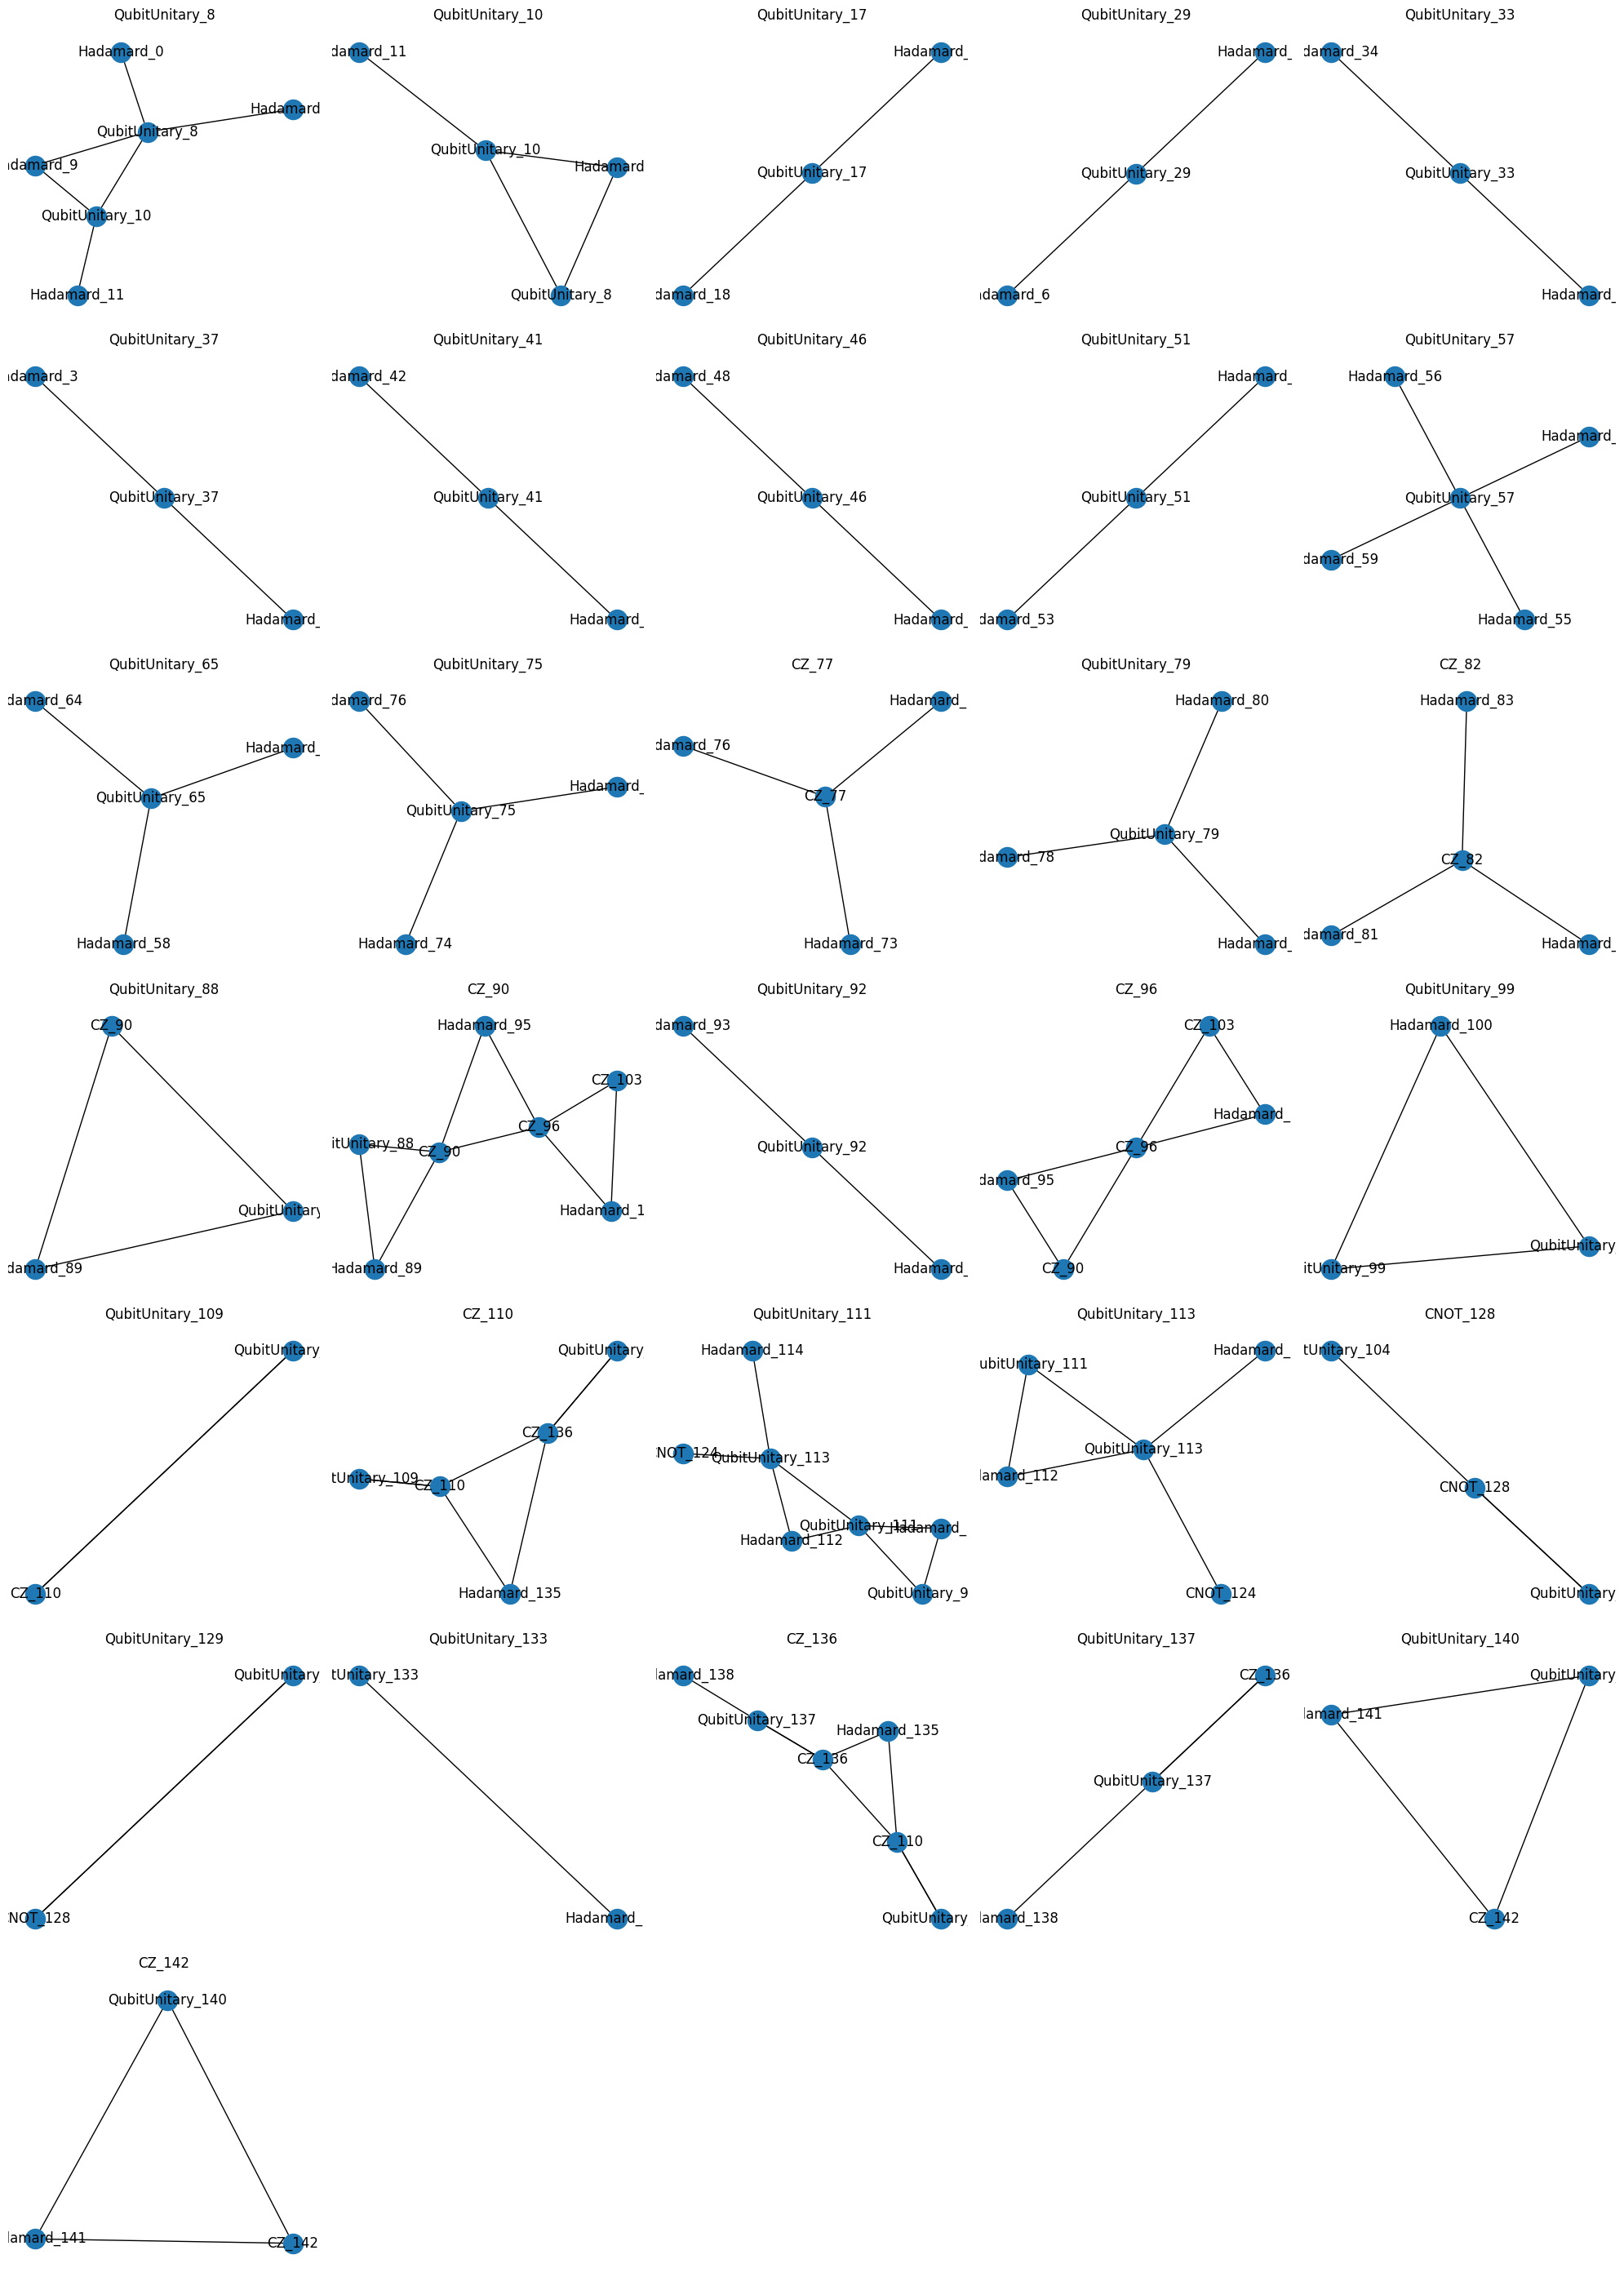

In [182]:
draw_subgraphs(new_subgraph)

In [233]:
unique_subgraphs = []

for candidate in new_subgraph:
    subG = candidate['subG']
    is_duplicate = any(nx.is_isomorphic(subG, existing['subG']) for existing in unique_subgraphs)
    
    if not is_duplicate:
        unique_subgraphs.append(candidate)

print(len(new_subgraph))
print(len(unique_subgraphs))

31
15


In [232]:
new_subgraph[0]

{'center': 'QubitUnitary_8',
 'wires': [0, 1],
 'subG': <networkx.classes.multigraph.MultiGraph at 0x201e2d4c490>,
 'nodes': ['Hadamard_1',
  'Hadamard_0',
  'QubitUnitary_8',
  'Hadamard_11',
  'Hadamard_9',
  'QubitUnitary_10']}

In [239]:
unique_subgraphs = [new_subgraph[0]]

for i in range(1, len(new_subgraph)):
    prev_nodes = set(new_subgraph[i - 1]['subG'].nodes())
    curr_nodes = set(new_subgraph[i]['subG'].nodes())

    # If they share nodes, keep the one with more nodes
    if prev_nodes & curr_nodes:
        if len(curr_nodes) > len(prev_nodes):
            unique_subgraphs[-1] = new_subgraph[i] 
    else:
        unique_subgraphs.append(new_subgraph[i])

print(len(new_subgraph))
print(len(unique_subgraphs))

31
21


In [240]:
# add node list
for idx, elem in enumerate(unique_subgraphs):
    unique_subgraphs[idx]['nodes'] = list(elem['subG'].nodes())

In [241]:
communities = []
for elem in unique_subgraphs:
    communities.append(set(elem['nodes']))
communities[:5]

[{'Hadamard_0',
  'Hadamard_1',
  'Hadamard_11',
  'Hadamard_9',
  'QubitUnitary_10',
  'QubitUnitary_8'},
 {'Hadamard_18', 'Hadamard_19', 'QubitUnitary_17'},
 {'Hadamard_30', 'Hadamard_6', 'QubitUnitary_29'},
 {'Hadamard_32', 'Hadamard_34', 'QubitUnitary_33'},
 {'Hadamard_3', 'Hadamard_38', 'QubitUnitary_37'}]

In [242]:
G = pg.G
barriers = [n for n in list(G.nodes()) if n not in set().union(*communities)] # those do not belong to any communities
print(len(G.nodes()), len(barriers))

145 75


In [243]:
# barriers as singleton communities
for barrier in barriers:
    communities.append({barrier})

# rearange community indices 
node_to_original_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_original_community[node] = i

##### internal function
def extract_index(name):
    match = re.search(r'_(\d+)$', name)
    return int(match.group(1)) if match else None
#####

sorted_nodes = sorted(G.nodes(), key=extract_index)

original_to_new_index = {}
new_index = 0
node_to_reindexed_community = {}

for node in sorted_nodes:
    original = node_to_original_community[node]
    if original not in original_to_new_index:
        original_to_new_index[original] = new_index
        new_index += 1
    node_to_reindexed_community[node] = original_to_new_index[original]

# community index as a node attribute
for node in G.nodes:
    G.nodes[node]['community'] = node_to_reindexed_community[node]

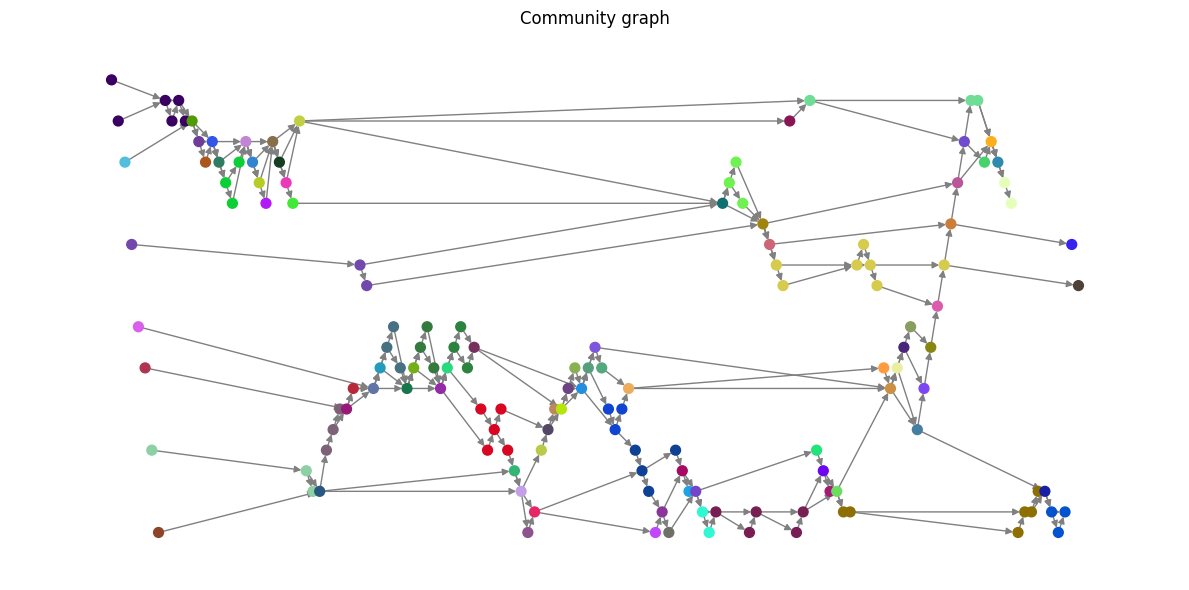

In [244]:
import random
def color_generator(n):
    random.seed(42)
    colors = []
    for _ in range(n):
        hex_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        colors.append(hex_color)
    return colors

palette = color_generator(len(communities))

# Step 2: Assign colors to communities
node_color_map = {}
for i, community in enumerate(communities):
    color = palette[i % len(palette)]
    for node in community:
        node_color_map[node] = color

# Step 3: Build node_colors list
pos = pg.pos
node_colors = [node_color_map.get(node, '#999999') for node in G.nodes]

# Step 4: Draw the graph
fig, ax = plt.subplots(figsize=(12, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=50, font_size=8, edge_color='gray', ax=ax)
plt.title('Community graph')
plt.tight_layout()
plt.show()

=== with functions 

In [ ]:
# with methods
G = pg.G
communities = get_communities(G)
G, communities = graph_alg_level_3(G, communities)
community_graph(G, pg.pos, communities)